In [1]:
import pandas as pd
sf = pd.read_csv('Relative_CPU_Performance.csv',encoding='ISO-8859-1')
sf.head()

,Vendor_Name,Model_Name,Machine_Cycle_Time,Min_Main_Memory,Max_Main_Memory,Cache_Memory,Min_Channel_Units,Max_Channel_Units,Relative_Performance
0,adviser,32/60,125,256,6000,256,16,128,198
1,amdahl,470v/7,29,8000,32000,32,8,32,269
2,amdahl,470v/7a,29,8000,32000,32,8,32,220
3,amdahl,470v/7b,29,8000,32000,32,8,32,172
4,amdahl,470v/7c,29,8000,16000,32,8,16,132


In [2]:
sf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 9 columns):
Vendor_Name             209 non-null object
Model_Name              209 non-null object
Machine_Cycle_Time      209 non-null int64
Min_Main_Memory         209 non-null int64
Max_Main_Memory         209 non-null int64
Cache_Memory            209 non-null int64
Min_Channel_Units       209 non-null int64
Max_Channel_Units       209 non-null int64
Relative_Performance    209 non-null int64
dtypes: int64(7), object(2)
memory usage: 14.8+ KB


In [3]:
sf.describe()

,Machine_Cycle_Time,Min_Main_Memory,Max_Main_Memory,Cache_Memory,Min_Channel_Units,Max_Channel_Units,Relative_Performance
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,203.822967,2867.980861,11796.153110,25.205742,4.698565,18.267943,105.622010
std,260.262926,3878.742758,11726.564377,40.628722,6.816274,25.997318,160.830733
min,17.000000,64.000000,64.000000,0.000000,0.000000,0.000000,6.000000
25%,50.000000,768.000000,4000.000000,0.000000,1.000000,5.000000,27.000000
50%,110.000000,2000.000000,8000.000000,8.000000,2.000000,8.000000,50.000000
75%,225.000000,4000.000000,16000.000000,32.000000,6.000000,24.000000,113.000000
max,1500.000000,32000.000000,64000.000000,256.000000,52.000000,176.000000,1150.000000


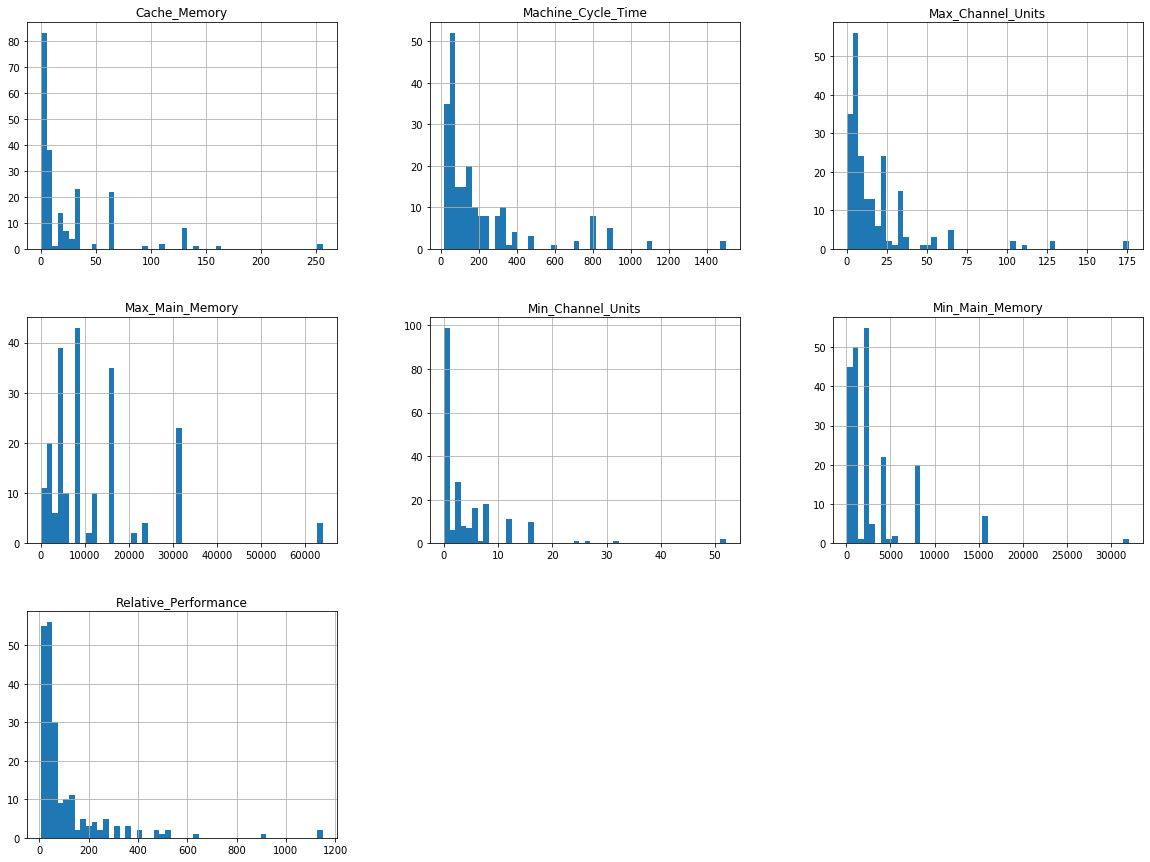

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
sf.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

Observations: 

1. These variables have very different scales. We will discuss this later in this chapter when we explore feature scaling.

2. Many histograms are right skewed: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

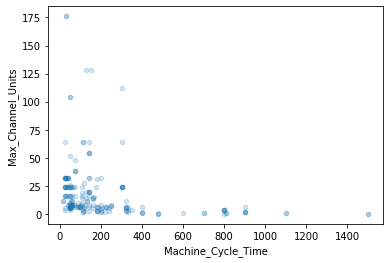

In [5]:
sf.plot(kind="scatter", x="Machine_Cycle_Time", y="Max_Channel_Units", alpha=0.2)
plt.savefig('map1.png')

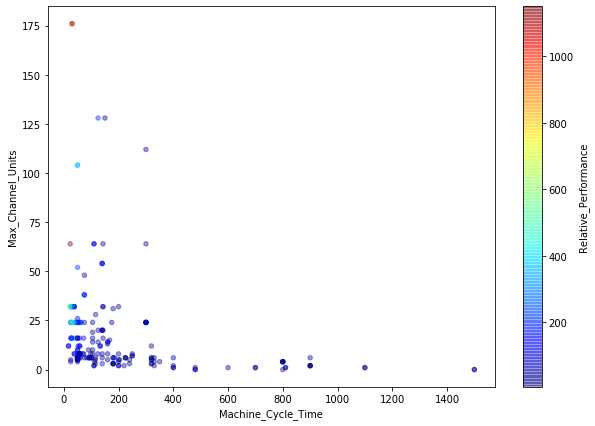

In [6]:
sf.plot(kind="scatter", x="Machine_Cycle_Time", y="Max_Channel_Units", alpha=0.4, figsize=(10,7),
    c="Relative_Performance", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.savefig('map2.png')

Now let’s look at how much each independent variable correlates with the Relative_Performance.

In [7]:
corr_matrix = sf.corr()
corr_matrix["Relative_Performance"].sort_values(ascending=False)

Relative_Performance    1.000000
Max_Main_Memory         0.863004
Min_Main_Memory         0.794931
Cache_Memory            0.662641
Min_Channel_Units       0.608903
Max_Channel_Units       0.605209
Machine_Cycle_Time     -0.307099
Name: Relative_Performance, dtype: float64

The Relative_Performance tends to go up when the Max_Main_Memory, Min_Main_Memory, Cache_Memory, Min_Channel_Units and Max_Channel_Units go up. You can see a small negative correlation between the Machine_Cycle_Time and the elative_Performance. 

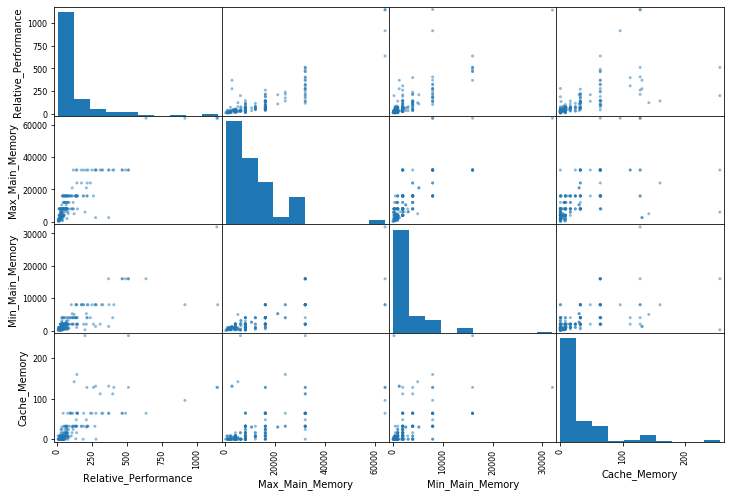

In [8]:
from pandas.plotting import scatter_matrix

attributes = ["Relative_Performance", "Max_Main_Memory", "Min_Main_Memory", "Cache_Memory"]
scatter_matrix(sf[attributes], figsize=(12, 8))
plt.savefig('matrix.png')

The most promising variable to predict the Relative_Performance is the Max_Main_Memory, so let’s zoom in on their correlation scatterplot

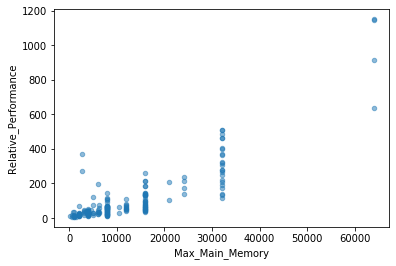

In [9]:
sf.plot(kind="scatter", x="Max_Main_Memory", y="Relative_Performance", alpha=0.5)
plt.savefig('scatter.png')

First, the correlation is indeed very strong; you can clearly see the upward trend and the points are not too dispersed.

Because each Model_Name has the different Relative_Performance, what we really want is the Relative_Performance per Machine_Cycle_Time. So, we add a new variable "RP_per_MCT". 

In [10]:
sf['RP_per_MCT'] = sf['Relative_Performance']/sf['Machine_Cycle_Time']

In [11]:
corr_matrix = sf.corr()
corr_matrix["RP_per_MCT"].sort_values(ascending=False)

RP_per_MCT              1.000000
Relative_Performance    0.967660
Min_Main_Memory         0.834718
Max_Main_Memory         0.817306
Cache_Memory            0.574548
Min_Channel_Units       0.561761
Max_Channel_Units       0.504456
Machine_Cycle_Time     -0.271238
Name: RP_per_MCT, dtype: float64

fortunately, the new RP_per_MCT variable has only a very strong positive correlation with the Relative_Performance. But we still need this varaible for grouping Model_Name.

We still need this varaible for grouping Model_Name. Also there are 209 Model_Name in the data, we are going to group them.

In [12]:
len(sf['Model_Name'].value_counts())

209

In [13]:
freq = sf.groupby('Model_Name').count()['Relative_Performance']
#mean_RP: average RP_per_MC
mean = sf.groupby('Model_Name').mean()['RP_per_MCT']
cluster = pd.concat([freq, mean], axis=1)
cluster['Model_Name'] = cluster.index

In [14]:
cluster.columns = ['freq', 'RP_per_MCT','Model_Name']

In [15]:
cluster.describe()

,freq,RP_per_MCT
count,209.0,209.000000
mean,1.0,2.648103
std,0.0,6.179186
min,1.0,0.006364
25%,1.0,0.139583
50%,1.0,0.426573
75%,1.0,1.892857
max,1.0,49.739130


Cluster the Model_Name into three groups: 1. low RP, 2. high RP low frequency, 3. high RP high frequency

In [16]:
cluster1 = cluster[cluster.RP_per_MCT < 0.139583]
cluster1.index

Index(['100', '3000/iii', '3205', '370/125-2', '370/148', '38/3', '38/4',
       '38/5', '38/7', '38/8', '4321', '4331-1', '4331-11', '4331-2', '4341',
       '4341-9', '5000', '68/10-80', '7.521', '7.531', '80', '80/3', '80/4',
       '80/5', '80/6', '8130-a', '8130-b', '8140', '8890/30', 'b1955', 'dn320',
       'dn420', 'dps:6/35', 'dps:6/92', 'dps:6/96', 'dps:7/35', 'dps:7/45',
       'eclipse:c/350', 'eclipse:m/600', 'f4000/100', 'f4000/200',
       'f4000/200ap', 'f4000/300', 'f4000/300ap', 'microvax-1', 'universe:68',
       'universe:68/05', 'universe:68/37', 'v8535:ii', 'vax:11/730',
       'vax:11/750', 'vs-90'],
      dtype='object', name='Model_Name')

In [17]:
cluster_temp = cluster[cluster.RP_per_MCT >= 0.139583]
cluster2 = cluster_temp[cluster_temp.RP_per_MCT < 1.892857]
cluster2.index

Index(['1100/61-h1', '1636-1', '1636-10', '1641-1', '1641-11', '1651-1',
       '2000/260', '300', '3000/30', '3000/40',
       ...
       'v8555:ii', 'v8565:ii', 'v8565:ii-e', 'v8575:ii', 'v8585:ii',
       'v8595:ii', 'v8635', 'vax:11/780', 'vs-100', 'éåì-65'],
      dtype='object', name='Model_Name', length=104)

In [18]:
cluster3 = cluster_temp[cluster_temp.RP_per_MCT >=1.892857]
cluster3.index

Index(['1100/81', '1100/82', '1100/83', '1100/84', '1100/93', '1100/94',
       '3033:s', '3033:u', '3081', '3081:d', '3083:b', '3083:e', '4361-4',
       '4361-5', '4381-1', '4381-2', '4480', '470v/7', '470v/7a', '470v/7b',
       '470v/7c', '470v/b', '580-5840', '580-5850', '580-5860', '580-5880',
       '7.561', '7.870-2', '7.872-2', '7.875-2', '7.880-2', '7.881-2',
       'as/6650', 'as/7000', 'as/8040', 'as/8050', 'as/8060', 'as/9000-dpc',
       'as/9000-n', 'as/9040', 'as/9060', 'concept:32/8705', 'concept:32/8750',
       'concept:32/8780', 'cyber:170/750', 'cyber:170/760', 'cyber:170/835',
       'cyber:170/845', 'v8650', 'v8655', 'v8665', 'v8670', 'éåì-68'],
      dtype='object', name='Model_Name')

Add model column based on the clusters

In [19]:
def get_group(x):
    if x in cluster1.index:
        return 'low_RP'
    elif x in cluster2.index:
        return 'high_RP_low_freq'
    else:
        return 'high_RP_high_freq'
sf['model'] = sf.Model_Name.apply(get_group)

In [20]:
sf.head()

,Vendor_Name,Model_Name,Machine_Cycle_Time,Min_Main_Memory,Max_Main_Memory,Cache_Memory,Min_Channel_Units,Max_Channel_Units,Relative_Performance,RP_per_MCT,model
0,adviser,32/60,125,256,6000,256,16,128,198,1.584000,high_RP_low_freq
1,amdahl,470v/7,29,8000,32000,32,8,32,269,9.275862,high_RP_high_freq
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,7.586207,high_RP_high_freq
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,5.931034,high_RP_high_freq
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,4.551724,high_RP_high_freq


In [21]:
len(sf['Vendor_Name'].value_counts())

30

In [22]:
freq = sf.groupby('Vendor_Name').count()['Relative_Performance']
#mean_RP: average RP_per_MC
mean = sf.groupby('Vendor_Name').mean()['RP_per_MCT']
cluster = pd.concat([freq, mean], axis=1)
cluster['Vendor_Name'] = cluster.index

In [23]:
cluster.columns = ['freq', 'RP_per_MCT','Vendor_Name']

In [24]:
cluster.describe()

,freq,RP_per_MCT
count,30.000000,30.000000
mean,6.966667,1.761274
std,6.483312,3.323933
min,1.000000,0.021000
25%,2.250000,0.194286
50%,6.000000,0.402153
75%,8.750000,2.006000
max,32.000000,17.131588


Cluster the Vendor_Name into three groups: 1. low RP, 2. high RP low frequency, 3. high RP high frequency

In [25]:
cluster1 = cluster[cluster.RP_per_MCT < 0.194286]
cluster1.index

Index(['apollo', 'bti', 'c.r.d', 'formation', 'harris', 'nixdorf',
       'perkin-elmer', 'wang'],
      dtype='object', name='Vendor_Name')

In [26]:
cluster_temp = cluster[cluster.RP_per_MCT >= 0.194286]
cluster2 = cluster_temp[cluster_temp.RP_per_MCT < 2.006000]
cluster2.index

Index(['adviser', 'burroughs', 'cambex', 'dec', 'dg', 'four-phase',
       'honeywell', 'hp', 'ipl', 'magnuson', 'microdata', 'ncr', 'prime',
       'sratus'],
      dtype='object', name='Vendor_Name')

In [27]:
cluster3 = cluster_temp[cluster_temp.RP_per_MCT >=2.006000]
cluster3.index

Index(['amdahl', 'basf', 'cdc', 'gould', 'ibm', 'nas', 'siemens', 'sperry'], dtype='object', name='Vendor_Name')

In [28]:
def get_group(x):
    if x in cluster1.index:
        return 'low_RP'
    elif x in cluster2.index:
        return 'high_RP_low_freq'
    else:
        return 'high_RP_high_freq'
sf['vendor'] = sf.Vendor_Name.apply(get_group)

In [29]:
sf.head()

,Vendor_Name,Model_Name,Machine_Cycle_Time,Min_Main_Memory,Max_Main_Memory,Cache_Memory,Min_Channel_Units,Max_Channel_Units,Relative_Performance,RP_per_MCT,model,vendor
0,adviser,32/60,125,256,6000,256,16,128,198,1.584000,high_RP_low_freq,high_RP_low_freq
1,amdahl,470v/7,29,8000,32000,32,8,32,269,9.275862,high_RP_high_freq,high_RP_high_freq
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,7.586207,high_RP_high_freq,high_RP_high_freq
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,5.931034,high_RP_high_freq,high_RP_high_freq
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,4.551724,high_RP_high_freq,high_RP_high_freq


In [30]:
sf.drop(sf.columns[[0, 1, 9]], axis=1, inplace=True)
sf.head()

,Machine_Cycle_Time,Min_Main_Memory,Max_Main_Memory,Cache_Memory,Min_Channel_Units,Max_Channel_Units,Relative_Performance,model,vendor
0,125,256,6000,256,16,128,198,high_RP_low_freq,high_RP_low_freq
1,29,8000,32000,32,8,32,269,high_RP_high_freq,high_RP_high_freq
2,29,8000,32000,32,8,32,220,high_RP_high_freq,high_RP_high_freq
3,29,8000,32000,32,8,32,172,high_RP_high_freq,high_RP_high_freq
4,29,8000,16000,32,8,16,132,high_RP_high_freq,high_RP_high_freq


In [31]:
sf.columns

Index(['Machine_Cycle_Time', 'Min_Main_Memory', 'Max_Main_Memory',
       'Cache_Memory', 'Min_Channel_Units', 'Max_Channel_Units',
       'Relative_Performance', 'model', 'vendor'],
      dtype='object')

In [32]:
sf = sf[['Machine_Cycle_Time', 'Min_Main_Memory', 'Max_Main_Memory',
       'Cache_Memory', 'Min_Channel_Units', 'Max_Channel_Units',
       'Relative_Performance', 'model', 'vendor']]
sf.head()

,Machine_Cycle_Time,Min_Main_Memory,Max_Main_Memory,Cache_Memory,Min_Channel_Units,Max_Channel_Units,Relative_Performance,model,vendor
0,125,256,6000,256,16,128,198,high_RP_low_freq,high_RP_low_freq
1,29,8000,32000,32,8,32,269,high_RP_high_freq,high_RP_high_freq
2,29,8000,32000,32,8,32,220,high_RP_high_freq,high_RP_high_freq
3,29,8000,32000,32,8,32,172,high_RP_high_freq,high_RP_high_freq
4,29,8000,16000,32,8,16,132,high_RP_high_freq,high_RP_high_freq


Create dummy variables for two categorical variables.

In [33]:
X = sf[['Machine_Cycle_Time', 'Min_Main_Memory', 'Max_Main_Memory',
       'Cache_Memory', 'Min_Channel_Units', 'Max_Channel_Units', 'model', 'vendor']]
Y = sf['Relative_Performance']
#create dummy variables for model
n = pd.get_dummies(sf.model)
X = pd.concat([X, n], axis=1)

In [34]:
X.columns

Index(['Machine_Cycle_Time', 'Min_Main_Memory', 'Max_Main_Memory',
       'Cache_Memory', 'Min_Channel_Units', 'Max_Channel_Units', 'model',
       'vendor', 'high_RP_high_freq', 'high_RP_low_freq', 'low_RP'],
      dtype='object')

In [35]:
X2 = X.rename({'low_RP': 'model_low_RP', 'high_RP_low_freq': 'model_high_RP_low_freq', 'high_RP_high_freq': 'model_high_RP_high_freq'}, axis=1)
X = X2
X.columns

Index(['Machine_Cycle_Time', 'Min_Main_Memory', 'Max_Main_Memory',
       'Cache_Memory', 'Min_Channel_Units', 'Max_Channel_Units', 'model',
       'vendor', 'model_high_RP_high_freq', 'model_high_RP_low_freq',
       'model_low_RP'],
      dtype='object')

In [36]:
m = pd.get_dummies(sf.vendor)
X = pd.concat([X, m], axis=1)

In [37]:
X.columns

Index(['Machine_Cycle_Time', 'Min_Main_Memory', 'Max_Main_Memory',
       'Cache_Memory', 'Min_Channel_Units', 'Max_Channel_Units', 'model',
       'vendor', 'model_high_RP_high_freq', 'model_high_RP_low_freq',
       'model_low_RP', 'high_RP_high_freq', 'high_RP_low_freq', 'low_RP'],
      dtype='object')

In [38]:
X2 = X.rename({'low_RP': 'vendor_low_RP', 'high_RP_low_freq': 'vendor_high_RP_low_freq', 'high_RP_high_freq': 'vendor_high_RP_high_freq'}, axis=1)
X = X2
X.columns

Index(['Machine_Cycle_Time', 'Min_Main_Memory', 'Max_Main_Memory',
       'Cache_Memory', 'Min_Channel_Units', 'Max_Channel_Units', 'model',
       'vendor', 'model_high_RP_high_freq', 'model_high_RP_low_freq',
       'model_low_RP', 'vendor_high_RP_high_freq', 'vendor_high_RP_low_freq',
       'vendor_low_RP'],
      dtype='object')

In [39]:
drops = ['model', 'vendor']
X.drop(drops, inplace=True, axis=1)

In [40]:
X.head()

,Machine_Cycle_Time,Min_Main_Memory,Max_Main_Memory,Cache_Memory,Min_Channel_Units,Max_Channel_Units,model_high_RP_high_freq,model_high_RP_low_freq,model_low_RP,vendor_high_RP_high_freq,vendor_high_RP_low_freq,vendor_low_RP
0,125,256,6000,256,16,128,0,1,0,0,1,0
1,29,8000,32000,32,8,32,1,0,0,1,0,0
2,29,8000,32000,32,8,32,1,0,0,1,0,0
3,29,8000,32000,32,8,32,1,0,0,1,0,0
4,29,8000,16000,32,8,16,1,0,0,1,0,0


In [41]:
X.shape

(209, 12)

In [42]:
X.columns

Index(['Machine_Cycle_Time', 'Min_Main_Memory', 'Max_Main_Memory',
       'Cache_Memory', 'Min_Channel_Units', 'Max_Channel_Units',
       'model_high_RP_high_freq', 'model_high_RP_low_freq', 'model_low_RP',
       'vendor_high_RP_high_freq', 'vendor_high_RP_low_freq', 'vendor_low_RP'],
      dtype='object')

In [43]:
Y.shape

(209,)

Standardization of the data

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [46]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Done! We now have a working Linear Regression model.

In [47]:
y_pred = regressor.predict(X_test)
print('Liner Regression R squared: %.4f' % regressor.score(X_test, y_test))

Liner Regression R squared: 0.9016


So, in our model, 90.16% of the variability in Y can be explained using X. It is exciting.

Calculate root-mean-square error (RMSE)

In [48]:
import numpy as np
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_pred, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Liner Regression RMSE: %.4f' % lin_rmse)

Liner Regression RMSE: 41.6221


Our model was able to predict the Relative_Performance of every Computer Hardware in the test set within 41.6221 of the real Performance.

Calculate mean absolute error (MAE)

In [49]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y_pred, y_test)
print('Liner Regression MAE: %.4f' % lin_mae)

Liner Regression MAE: 32.8293


let’s try a more complex model to see whether results can be improved - the RandomForestRegressor

In [50]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [51]:
print('Random Forest R squared": %.4f' % forest_reg.score(X_test, y_test))

Random Forest R squared": 0.9088


In [52]:
y_pred = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_pred, y_test)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: %.4f' % forest_rmse)

Random Forest RMSE: 40.0675


Much better! Let's try one more.

In [53]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [54]:
print('Gradient Boosting R squared": %.4f' % model.score(X_test, y_test))

Gradient Boosting R squared": 0.9131


In [55]:
y_pred = model.predict(X_test)
model_mse = mean_squared_error(y_pred, y_test)
model_rmse = np.sqrt(model_mse)
print('Gradient Boosting RMSE: %.4f' % model_rmse)

Gradient Boosting RMSE: 39.1233


I would consider this is our final model, let's print out feature importance

In [56]:
feature_labels = np.array(['Machine_Cycle_Time', 'Min_Main_Memory', 'Max_Main_Memory',
       'Cache_Memory', 'Min_Channel_Units', 'Max_Channel_Units',
       'model_high_RP_high_freq', 'model_high_RP_low_freq', 'model_low_RP',
       'vendor_high_RP_high_freq', 'vendor_high_RP_low_freq', 'vendor_low_RP'])
importance = model.feature_importances_
feature_indexes_by_importance = importance.argsort()[::-1]
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

Max_Main_Memory-71.49%
model_high_RP_high_freq-14.65%
Cache_Memory-6.60%
Min_Channel_Units-2.70%
Min_Main_Memory-2.63%
Max_Channel_Units-0.96%
Machine_Cycle_Time-0.42%
vendor_high_RP_low_freq-0.20%
vendor_high_RP_high_freq-0.12%
model_low_RP-0.10%
model_high_RP_low_freq-0.10%
vendor_low_RP-0.03%
